In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from Preprocessing.to_embedding import WordEmbedding
from Preprocessing.data_format import formatting
from Preprocessing.helper_functions import import_embedding, embedding_matrix_word2vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence
import keras

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

keras.backend.tensorflow_backend._get_available_gpus()
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11513796383185588248
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6065664820
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16791071538593610544
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [6]:
data = pd.read_csv('phase2_baby_all.csv')

data["sentence"] = data["sentence"].astype(str)
data["sentence"] = data["sentence"].apply(text_to_word_sequence)

embedding_size = 300 #number of feature weights in embeddings
max_len = 400

avg_len = sum(data["sentence"].str.len())/len(data["sentence"])
max_len = data["sentence"].str.len()
print(avg_len)
print(max(max_len))

15.307844640347515
148


In [5]:
embedding = WordEmbedding(num_features = embedding_size)
WordEmbedding.fit(embedding, data["sentence"])
WordEmbedding.size(embedding)

Total number of words in the vocabulary:  (2979, 300)


In [6]:
#Save word embedding to dataframe
#train_embeddings = WordEmbedding.to_pd(embedding, X_train)

#Save Save embeddings to file
WordEmbedding.to_file(embedding)

In [7]:
embeddings_index = import_embedding('trained_embedding_word2vec.txt')

## 2. Vectorize text data

In [8]:
def vectorize(data, tokenizer ,max_len):
    sequences = tokenizer.texts_to_sequences(data)
    padding = pad_sequences(sequences, maxlen = max_len)
    
    return padding

### Check train/dev sets

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, GlobalMaxPool1D, Dropout, CuDNNGRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from sklearn.model_selection import StratifiedKFold


cvscores = []
for group_id in range(1,9):
    train = data.loc[data['group_id'] != group_id]
    X_train = train['sentence']
    y_train = train['sentiment']
    
    test = data.loc[data['group_id'] == group_id]
    X_test = test['sentence']
    y_test = test['sentiment']
    
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    
    embedding_matrix, num_words = embedding_matrix_word2vec(word_index, embedding_size, embeddings_index)
    
    X_train = vectorize(X_train, tokenizer , max_len)
    X_test = vectorize(X_test, tokenizer, max_len)

    # Define Model
    model = Sequential()
    model.add(Embedding(num_words, 
                        embedding_size,
                        input_length = max_len,
                         dropout=0.2))
    model.add(Bidirectional(CuDNNGRU(128, return_sequences = True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(20, activation="relu"))
    model.add(Dropout(0.05))
    model.add(Dense(3, activation="softmax"))
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    model.fit(X_train, y_train, batch_size = 64, epochs = 3, verbose = 1)
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1])
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

/home/dsproj016/anaconda3/envs/py36tfnew/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.


Epoch 1/3
13950/13950 [==============================] - 17s 1ms/step - loss: 0.5617 - acc: 0.7075
Epoch 2/3
13950/13950 [==============================] - 16s 1ms/step - loss: 0.4599 - acc: 0.7774
Epoch 3/3
13950/13950 [==============================] - 16s 1ms/step - loss: 0.3719 - acc: 0.8353
acc: 75.27%


/home/dsproj016/anaconda3/envs/py36tfnew/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.


Epoch 1/3
13903/13903 [==============================] - 17s 1ms/step - loss: 0.5662 - acc: 0.7053
Epoch 2/3
13903/13903 [==============================] - 16s 1ms/step - loss: 0.4705 - acc: 0.7688
Epoch 3/3
13903/13903 [==============================] - 16s 1ms/step - loss: 0.3832 - acc: 0.8277
acc: 75.94%
Epoch 1/3
13900/13900 [==============================] - 17s 1ms/step - loss: 0.5547 - acc: 0.7096
Epoch 2/3
13900/13900 [==============================] - 16s 1ms/step - loss: 0.4499 - acc: 0.7835
Epoch 3/3
13900/13900 [==============================] - 16s 1ms/step - loss: 0.3633 - acc: 0.8385
acc: 76.02%
Epoch 1/3
13797/13797 [==============================] - 17s 1ms/step - loss: 0.5690 - acc: 0.7035
Epoch 2/3
13797/13797 [==============================] - 16s 1ms/step - loss: 0.4653 - acc: 0.7743
Epoch 3/3
13797/13797 [==============================] - 16s 1ms/step - loss: 0.3736 - acc: 0.8364
acc: 79.30%
Epoch 1/3
13826/13826 [==============================] - 17s 1ms/step - l

In [10]:
cvscores

[0.7527386705640337,
 0.7593756153677478,
 0.7601672537378465,
 0.7930353839486018,
 0.7722465573306678,
 0.716790564984441,
 0.6756909410293265,
 0.7021447399690506]

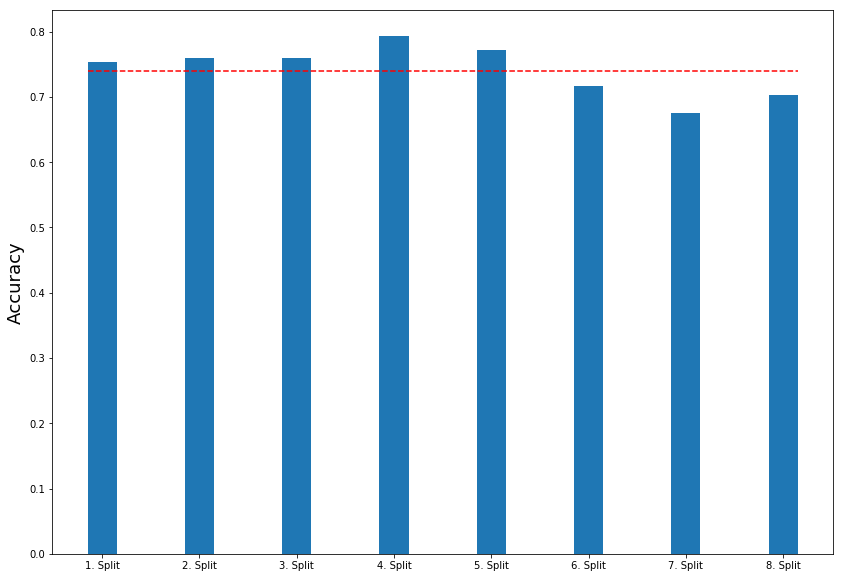

In [35]:

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 10]



x = np.arange(8)
acc = cvscores





fig, ax = plt.subplots()

plt.bar(x, acc,width=0.3,align='center')
plt.xticks(x, ('1. Split',
               '2. Split',
               '3. Split',
               '4. Split',
               '5. Split',
               '6. Split',
               '7. Split',
               '8. Split'))
plt.ylabel('Accuracy', fontsize=18)
plt.hlines(0.74, -0.15, 7.15, colors='r', linestyles='dashed', label='')